# Test predizione COVID con BackFeatureMapper

In [39]:
import pickle
import numpy as np
import pandas as pd
from aidam.miscellanea_utils import var_column_mapper
from matplotlib import pyplot as plt
from aidam.BackFeatureMapper import BackFeatureBrewer, BackFeatureMapper
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [40]:
data_file='stored_data.pkl'

## Data import e preprocessing

In [41]:
# lettura dati
infile=open(data_file,'rb')
trend=pickle.load(infile)
regioni=pickle.load(infile)
giorni=pickle.load(infile)
giorno_settimana=pickle.load(infile)
infile.close()

### Creazione della matrice di input e target

In [42]:
# selezione regione oggetto dello studio
regione='Italia'

# costruzione matrici di input e target
input_vars=['totale_positivi']
target_var='nuovi_positivi'
input_list=[]
input_list=[trend[v][regione] for v in input_vars]
input_data=np.array(input_list).T
target_data=trend[target_var][regione]


scaler=StandardScaler()
scaler.fit(input_data)
input_data=scaler.transform(input_data)


### Divisione training test

In [43]:
num_samples=len(giorni)

num_tr_samples=int(num_samples*0.7)
num_tr_samples

input_tr=input_data[0:num_tr_samples,:]
input_ts=input_data[num_tr_samples:,:]

target_tr=target_data[0:num_tr_samples]
target_ts=target_data[num_tr_samples:]


print('RAW DATA')
print('%d Training samples   %d Validation samples'%(len(target_tr),len(target_ts)))

RAW DATA
450 Training samples   194 Validation samples


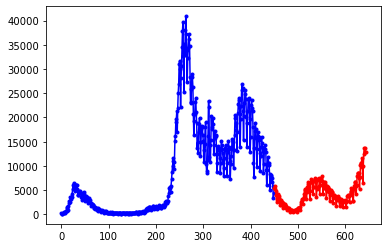

In [44]:
plt.plot(list(range(0,num_tr_samples)),target_tr,'b.-')
plt.plot(list(range(num_tr_samples,num_samples)),target_ts,'r.-')

## Training e test modello

### Preparazione e applicazione del mapper

In [51]:
eso_backsight=7
endo_backsight=7
foresight=10

def difference(x):
    return x[-1]-x[0]

'''
eso=[BackFeatureMapper(column=0,backsight=eso_backsight,mapfun=np.mean),
     BackFeatureMapper(column=0,backsight=eso_backsight,mapfun=difference)
    ]'''
eso = [BackFeatureMapper(column=0, backsight=eso_backsight, mapfun=np.mean)
       ]
endo=[BackFeatureMapper(column=0,backsight=endo_backsight,mapfun=np.mean)]


#the_brewer=BackFeatureBrewer(esomappers=eso, endomappers=endo)
the_brewer=BackFeatureBrewer(esomappers=eso)


In [53]:
indici_tr,tr_myin,tr_mytar=the_brewer.transform(input_tr,
                                      target_tr,
                                      map_target=True,
                                      foresight=foresight)

indici_ts,ts_myin=the_brewer.transform(input_ts,target_ts,
                                      map_target=False,
                                      foresight=foresight)

print('FEATURES DATA')
print('%d Training samples   %d Validation samples'%(tr_myin.shape[0],ts_myin.shape[0]))

whole_cut=input_tr.shape[0]-tr_myin.shape[0]
head_cut=whole_cut-foresight

print('Whole cut: %d'%whole_cut)
print('Head cut: %d'%head_cut)

FEATURES DATA
433 Training samples   187 Validation samples
Whole cut: 17
Head cut: 7


### Training e test modello

In [54]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=1)

model.fit(tr_myin,tr_mytar)

tr_pred=model.predict(tr_myin)
ts_pred=model.predict(ts_myin)

print(tr_pred.shape)
print(ts_pred.shape)

(433,)
(187,)


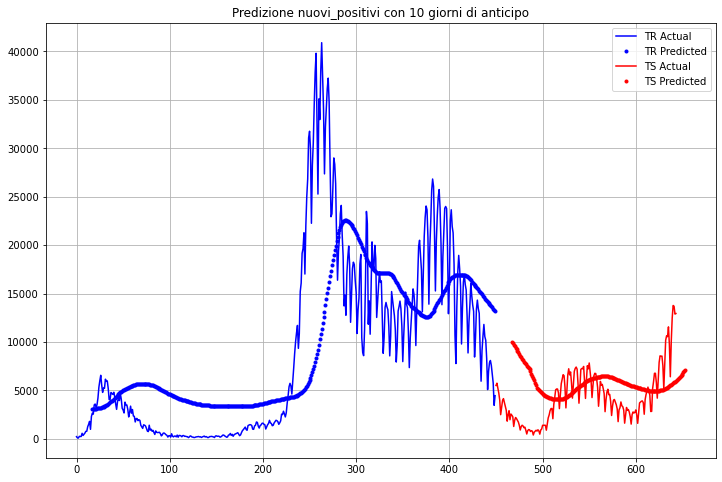

In [55]:
#print('Errore TR: %5.2f   Errore TS: %5.2f'%(errore_tr,errore_ts))

plt.figure(figsize=(12,8))
plt.plot(range(len(target_tr)),target_tr,'b',label='TR Actual')
plt.plot(range(whole_cut,len(target_tr)),tr_pred,'b.',label='TR Predicted')
plt.plot(range(len(target_tr),num_samples),target_ts,'r',label='TS Actual')
plt.plot(range(len(target_tr)+whole_cut,len(target_tr)+len(ts_pred)+whole_cut),ts_pred,'r.',label='TS Predicted')
plt.title('Predizione %s con %d giorni di anticipo'%(target_var,foresight))
plt.legend()
plt.grid()
plt.show()

In [49]:
giorni

array(['2020-02-24T18:00:00', '2020-02-25T18:00:00',
       '2020-02-26T18:00:00', '2020-02-27T18:00:00',
       '2020-02-28T18:00:00', '2020-02-29T17:00:00',
       '2020-03-01T17:00:00', '2020-03-02T18:00:00',
       '2020-03-03T18:00:00', '2020-03-04T17:00:00',
       '2020-03-05T17:00:00', '2020-03-06T17:00:00',
       '2020-03-07T18:00:00', '2020-03-08T18:00:00',
       '2020-03-09T18:00:00', '2020-03-10T18:00:00',
       '2020-03-11T17:00:00', '2020-03-12T17:00:00',
       '2020-03-13T17:00:00', '2020-03-14T17:00:00',
       '2020-03-15T17:00:00', '2020-03-16T17:00:00',
       '2020-03-17T17:00:00', '2020-03-18T17:00:00',
       '2020-03-19T17:00:00', '2020-03-20T17:00:00',
       '2020-03-21T17:00:00', '2020-03-22T17:00:00',
       '2020-03-23T17:00:00', '2020-03-24T17:00:00',
       '2020-03-25T17:00:00', '2020-03-26T17:00:00',
       '2020-03-27T17:00:00', '2020-03-28T17:00:00',
       '2020-03-29T17:00:00', '2020-03-30T17:00:00',
       '2020-03-31T17:00:00', '2020-04-01T17:0

In [50]:
ts_pred

array([ 3804.45243564,  3683.22279601,  3605.86999551,  3885.52461895,
        3623.26020767,  3477.30075378,  3360.73682484,  2291.57609618,
        2393.9976037 ,  2408.19054689,  2187.00599701,  2097.17049607,
        2033.72812479,  2009.5464766 ,  2889.9024269 ,  2628.47069622,
        2653.10694065,  2766.69545814,  2773.02436511,  2815.618866  ,
       -2718.94652902, -2650.8778189 , -2613.79302281, -3145.45692454,
       -3396.22502884, -3555.24473968, -4791.89982513,   546.15515128,
         394.19514996,   -88.29984044,   311.79760039,   252.40968025,
         253.11628094,  1127.33206813,  1288.74585517,  1446.85137596,
        1996.58681827,  2008.56608677,  1997.36314497,  1916.19578629,
        2030.52140395,  2098.15992862,  2255.52401387,  2310.38079857,
        2461.15989633,  2652.62571921,  2752.67302327,  2795.13288123,
        2923.27726802,  3129.56984886,  3076.49900251,  3300.82098562,
        3442.67978784,  3757.29279279,  4019.03836285,  4229.49878148,
      